In [2]:
import pandas as pd
import pickle
from IPython.display import display
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

%matplotlib inline

In [3]:
remap_dict = {
    ('unmeasure', 'blur'): 'unmeasure-blur',
    ('unmeasure', 'inpaint-tv') : 'unmeasure-inpaint-tv',
    ('baseline', 'None') : 'ignore',
    ('ambient', 'None') : 'AmbientGAN (ours)',
    ('unmeasure', 'wiener'): 'unmeasure-weiner',
    'pad_rotate_project': 'Pad-Rotate-Project',
    'pad_rotate_project_with_theta': r'Pad-Rotate-Project-$\theta$',
}

In [4]:
def save_plot(save_path):
    pdf = PdfPages(save_path)
    pdf.savefig(bbox_inches='tight')
    pdf.close()   
    
def errorbar(x, y, std):
    (_, caps, _) = plt.errorbar(x, y, yerr=1.96*std,
                                marker='o', markersize=5, capsize=5,
                                alpha=0.8, linewidth=2)
    for cap in caps:
        cap.set_markeredgewidth(1)

def plot(plot_spec, df):
    groups = df.groupby(plot_spec['group_by'])
    legends = []
    x_var = plot_spec['x_var']
    y_var = plot_spec['y_var']
    std_var = plot_spec['std_var']
    
    plt.figure(figsize=[6, 4])
    
    for key in sorted(groups.groups):
        val = groups.groups[key]
        group_df = df.loc[val, :]
        cols = [x_var, y_var, std_var]
        group_df.sort_values(by=[x_var], inplace=True)
        x = np.array(group_df[x_var])
        y = np.array(group_df[y_var])
        if std_var is not None:
            std = np.array(group_df[std_var])
            errorbar(x, y, std)
        else:
            plt.plot(x, y, '-o', alpha=0.8, linewidth=2)
        legend = remap_dict[key]
        legends.append(legend)
        
    ## Prettify
    # axis
    plt.gca().set_ylim(bottom=0)
    # plt.gca().set_xscale("log", nonposx='clip')
    # plt.gca().set_xlim([-0.1, 1.1])

    # labels, ticks, titles
    # ticks = [10, 25, 50, 100, 200, 300, 400, 500, 750]
    # labels = [10, 25, 50, 100, 200, 300, 400, 500, 750]
    # plt.xticks(ticks, labels, rotation=90)
    plt.xlabel(plot_spec['x_label'], fontsize=14)
    plt.ylabel(plot_spec['y_label'], fontsize=14)

    # Legends
    plt.legend(legends, fontsize=12.5, loc=3)
    # plt.ylim([0, 0.1])
    
    plt.title(plot_spec['title'])

In [9]:
def convert_df(df, convert_spec):
    for colname in convert_spec['float']:
        df.loc[:, colname] = df[colname].apply(np.float32)
    return df

def filter_df(df, filter_spec):
    df = df[filter_spec['cols']]
    filter_ = True
    for colname, values in filter_spec['in'].items():
        filter_ = filter_ & df[colname].isin(values)
    df = df[filter_]
    return df

In [6]:
def main(df_filepath, convert_spec, filter_spec, plot_spec):
    with open(df_filepath, 'rb') as df_pkl_file:
        df = pickle.load(df_pkl_file)
    df = convert_df(df, convert_spec)
    df = filter_df(df, filter_spec)    
    display(df)
    plot(plot_spec, df)

/tmp/ipykernel_17440/4014647567.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, colname] = df[colname].apply(np.float32)


,measurement_type,train_mode,drop_prob,unmeasure_type,m_inception_score_mean,model_type
0,drop_independent,baseline,0.0,None,7.976141,wgangp
1,drop_independent,unmeasure,0.0,inpaint-tv,7.812182,wgangp
2,drop_independent,unmeasure,0.0,blur,7.677939,wgangp
6,drop_independent,baseline,0.1,None,8.290941,wgangp
7,drop_independent,ambient,0.1,None,7.428875,wgangp
8,drop_independent,unmeasure,0.1,inpaint-tv,5.777950,wgangp
9,drop_independent,unmeasure,0.1,blur,8.205739,wgangp
11,drop_independent,ambient,0.8,None,7.343125,wgangp
12,drop_independent,unmeasure,0.8,blur,5.917746,wgangp


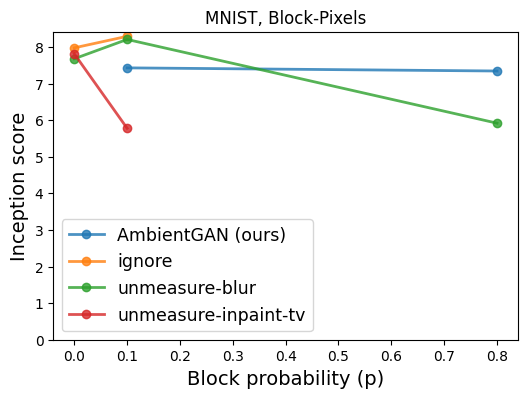

In [10]:
df_filepath = './results/df_mnist.pkl'

convert_spec = {
    'float': [
        'drop_prob',
        'm_inception_score_mean', 
#         'm_inception_score_std',
    ]        
}

filter_spec = {
    'cols' : ['measurement_type', 
              'train_mode', 
              'drop_prob',
              'unmeasure_type', 
              'm_inception_score_mean',
#               'm_inception_score_std',
              'model_type',
             ],
    'in': {
        'measurement_type': ['drop_independent'],
        'model_type' : ['wgangp'],
    }
}
plot_spec = {
    'group_by': ['train_mode', 'unmeasure_type'],
    # change these to lambda if needed
    'x_var': 'drop_prob',
    'y_var': 'm_inception_score_mean',
#     'std_var': 'm_inception_score_std',
    'std_var': None,
    'x_label': 'Block probability (p)',
    'y_label': 'Inception score',
    'title': 'MNIST, Block-Pixels',
}

main(df_filepath, convert_spec, filter_spec, plot_spec)
fig_savepath = './results/plots/mnist_drop_independent.pdf'
save_plot(fig_savepath)

/tmp/ipykernel_17440/4014647567.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, colname] = df[colname].apply(np.float32)


,measurement_type,train_mode,additive_noise_std,unmeasure_type,m_inception_score_mean
10,blur_addnoise,baseline,0.5,None,8.642074
13,blur_addnoise,unmeasure,0.1,wiener,5.180515
14,blur_addnoise,ambient,0.1,None,5.818780


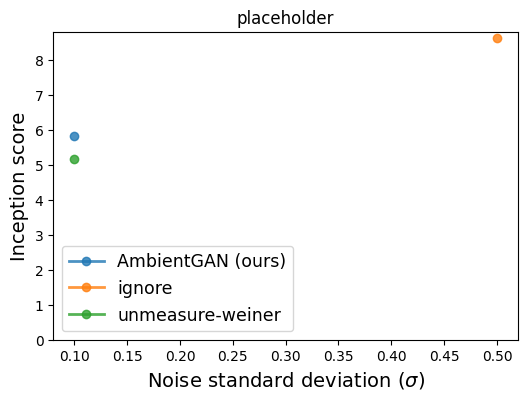

In [11]:
df_filepath = './results/df_mnist.pkl'

convert_spec = {
    'float': ['additive_noise_std', 'm_inception_score_mean']        
}

filter_spec = {
    'cols' : ['measurement_type', 
              'train_mode', 
              'additive_noise_std',
              'unmeasure_type', 
              'm_inception_score_mean'
             ],
    'in': {
        'measurement_type': ['blur_addnoise']
    }
}
plot_spec = {
    'group_by': ['train_mode', 'unmeasure_type'],
    # change these to lambda if needed
    'x_var': 'additive_noise_std',
    'y_var': 'm_inception_score_mean',
    'std_var': None,
    'x_label': 'Noise standard deviation ($\sigma$)',
    'y_label': 'Inception score',
    'title': 'placeholder',
}

main(df_filepath, convert_spec, filter_spec, plot_spec)
fig_savepath = './results/plots/mnist_blur_noise.pdf'
save_plot(fig_savepath)

/tmp/ipykernel_17440/4014647567.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, colname] = df[colname].apply(np.float32)


,measurement_type,train_mode,additive_noise_std,unmeasure_type,m_inception_score_mean,num_angles


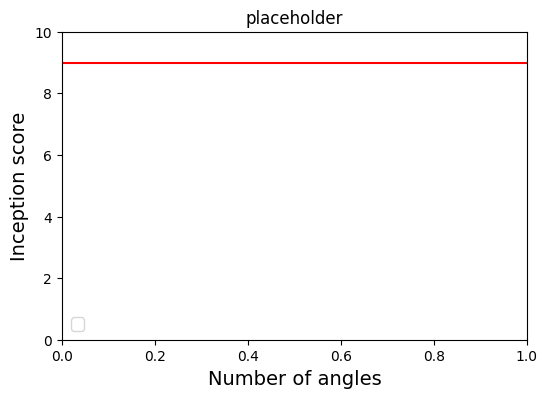

In [12]:
df_filepath = './results/df_mnist.pkl'

convert_spec = {
    'float': ['additive_noise_std', 'm_inception_score_mean']        
}

filter_spec = {
    'cols' : ['measurement_type', 
              'train_mode', 
              'additive_noise_std',
              'unmeasure_type', 
              'm_inception_score_mean',
              'num_angles',
             ],
    'in': {
        'measurement_type': [
            'pad_rotate_project',
            'pad_rotate_project_with_theta',
        ]
    }
}
plot_spec = {
    'group_by': ['measurement_type'],
    # change these to lambda if needed
    'x_var': 'num_angles',
    'y_var': 'm_inception_score_mean',
    'std_var': None,
    'x_label': 'Number of angles',
    'y_label': 'Inception score',
    'title': 'placeholder',
}

main(df_filepath, convert_spec, filter_spec, plot_spec)
plt.axhline(y=8.994174, color='red')
plt.ylim([0, 10])

fig_savepath = './results/plots/mnist_1d.pdf'
save_plot(fig_savepath)